## First Option: install conda first. This cell will crash the kernel. Just run everything again without restarting the kernel

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c astra-toolbox astra-toolbox --yes

import random
import astra
import matplotlib.pyplot as plt
from skimage import draw
import numpy as np
from PIL import Image
from os import mkdir
from os.path import isdir

✨🍰✨ Everything looks OK!
Channels:
 - astra-toolbox
 - conda-forge
Platform: linux-64
Solving environment: | / - done

# All requested packages already installed.



## Seond Option: install astra from scratch, not needed if alread installed from conda

In [ ]:
! apt install build-essential autoconf libtool
! pip install cython
! git clone https://github.com/astra-toolbox/astra-toolbox.git
! cd astra-toolbox/build/linux && ./autogen.sh && ./configure --with-cuda=/usr/local/cuda --with-python --with-install-type=module
! cd astra-toolbox/build/linux && make install -j 4

import random
import astra
import matplotlib.pyplot as plt
from skimage import draw
import numpy as np
from PIL import Image
from os import mkdir
from os.path import isdir

## Phantom *creation*

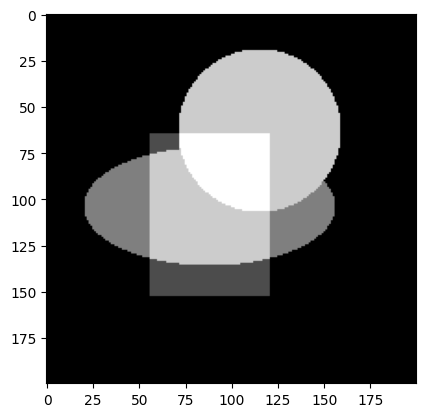

In [ ]:
# you can change the seed to generate a slightly different phantom
random.seed(1)

img = np.zeros((200, 200))
intensity=20

rr, cc = draw.ellipse(100+random.randint(0, intensity), 70+random.randint(0, intensity), 30+random.randint(0, intensity), 60+random.randint(0, intensity), shape=img.shape)
img[rr, cc] = 0.5

rr, cc = draw.disk((60+random.randint(0, intensity), 100+random.randint(0, intensity)), 30+random.randint(0, intensity), shape=img.shape)
img[rr, cc] = 0.8

rr, cc = draw.rectangle((50+random.randint(0, intensity), 100+random.randint(0, intensity)), (140+random.randint(0, intensity), 50+random.randint(0, intensity)), shape=img.shape)
img[rr, cc] += 0.3

img = img*255
img[img > 255] = 255
img[img < 0] = 0
img = img.astype(np.int16)

plt.imshow(img, cmap='gray')
plt.show()

## Utility functions

In [ ]:
def project_from_2D(phantom_id, vol_geom, n_projections,
                    n_detectors, detector_spacing, angles,
                    noise_factor=None, save_dir=None, use_gpu=False):
        """ Creates projection for the given input data.

            Parameters:
                - phantom_data: numpy array containing the 2D phantom.
                - n_projections: defines the number of projections
                    (number of angles from where to sample measurements
                - detector_spacing: pixel size
                - angles:
                - noise_factor:
                - save_dir: path of the directory to save image representation
                    of projections, when defined. To be passed as a string.
                - use_gpu: (boolean) set to True to use gpu.

            Returns:
                projector_id, sinogram_id and sinogram matrix
        """

        # create projection geometry
        proj_geom = astra.create_proj_geom('parallel', detector_spacing,
                                            n_detectors, angles)
        # choose projector
        if use_gpu:
            proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
        else:
            proj_id = astra.create_projector('linear', proj_geom, vol_geom)
        sino_id, sinogram = astra.creators.create_sino(phantom_id, proj_id)
        # Apply Poisson noise.
        if noise_factor != None:
            sinogram += np.random.poisson(lam=noise_factor, size=sinogram.shape)
            sino_id = astra.data2d.create('-sino', proj_geom, sinogram)
        # Save projections as images, if directory has been defined.
        if save_dir != None:
            if save_dir[-1] != '/':
                save_dir += '/'
            if not isdir(save_dir):
                mkdir(save_dir)
            proj_for_img = np.round(sinogram * (2**8- 1)).astype(np.uint8)
            for i in range(n_projections):
                Image.fromarray(proj_for_img[i]).save(save_dir+f'proj_{i}.png')

        return proj_id, sino_id, sinogram

def SART(vol_geom, vol_data, projector_id, sino_id, iters=2000, use_gpu=False):
        """ Simultaneous Algebraic Reconstruction Technique (SART) with
            randomized scheme. Used from DART as the continious update step.
        """
        # create starting reconstruction
        rec_id = astra.data2d.create('-vol', vol_geom, data=vol_data)
        # define SART configuration parameters
        alg_cfg = astra.astra_dict('SART_CUDA' if use_gpu else 'SART')
        alg_cfg['ProjectorId'] = projector_id
        alg_cfg['ProjectionDataId'] = sino_id
        alg_cfg['ReconstructionDataId'] = rec_id
        alg_cfg['option'] = {}
        alg_cfg['option']['MinConstraint'] = 0
        alg_cfg['option']['MaxConstraint'] = 255
        # define algorithm
        algorithm_id = astra.algorithm.create(alg_cfg)
        # run the algirithm
        astra.algorithm.run(algorithm_id, iters)
        # create reconstruction data
        rec = astra.data2d.get(rec_id)

        return rec_id, rec

## Computation

In [ ]:
# measurement parameters
n_projections = 10
n_detectors = 512
det_spacing = 1
noise_factor = None
angles = np.linspace(0, 180, n_projections)
rec_alg = 'SART_CUDA'
rec_iters = 10000

# open phantom
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare data for measurements
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)

# make measurements
projector_id, sino_id, sinogram = project_from_2D(phantom_id=phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing,
                                        n_detectors, angles)



Mean absolute pixel error: 3.998


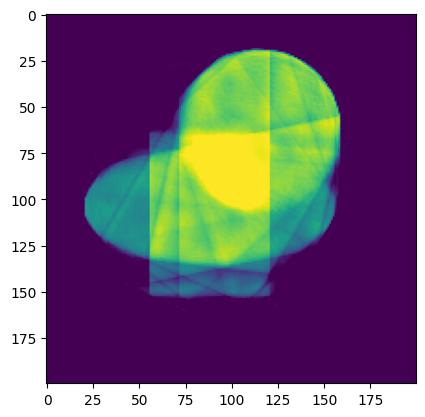

In [ ]:
_, sart_res = SART(vol_geom,0,projector_id,sino_id,
                    iters=rec_iters, use_gpu=True)
print(f"Mean absolute pixel error: {np.abs(img - sart_res).mean():.3f}")
plt.imshow(sart_res)